In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'resnet50_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o /content/drive/MyDrive/dataset_19.zip
# ! unzip -o /content/drive/MyDrive/Brain_MRI.zip
!pip install optuna optuna-integration
! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"
# validation_dir = "Testing"

# Data distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
pituitary     120
glioma        120
notumor       120
dtype: int64

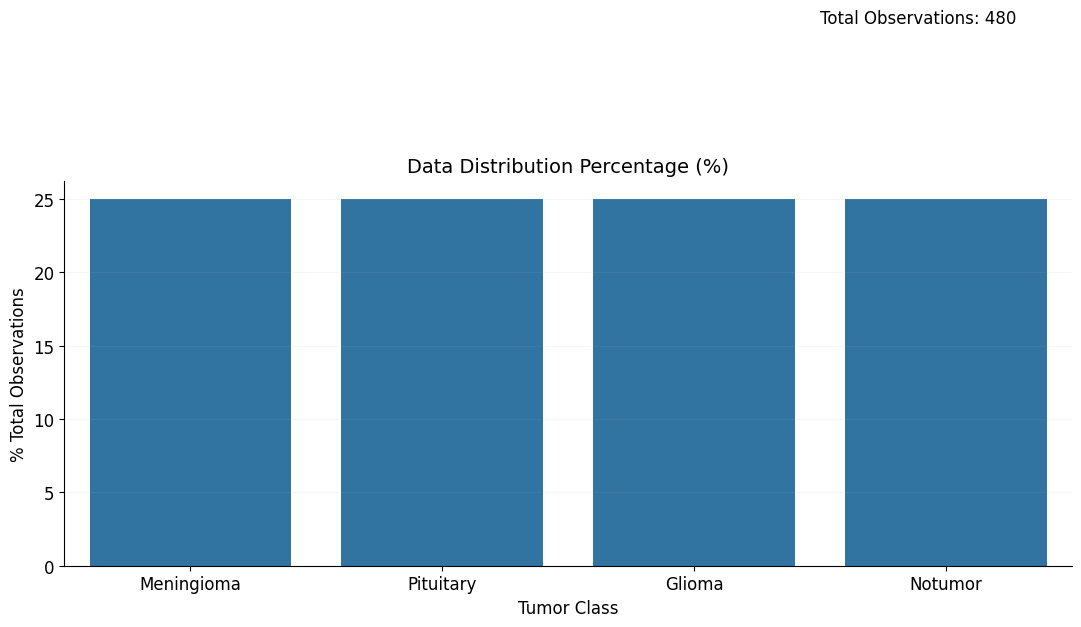

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

In [7]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)

# Fine tuning hyperparameters

In [ ]:
import os
import optuna
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet50
from keras.utils import plot_model

classes = os.listdir(dir)

# Data generator setup
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

# Model creation function modified for Optuna
def create_model(input_shape, num_classes, trial):
    # Suggest hyperparameters
    n_neurons = trial.suggest_int('n_neurons', 256, 1024, log=True)
    #n_neurons2 = trial.suggest_int('n_neurons2', 128, 512, log=True)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    dropout_rate2 = trial.suggest_uniform('dropout_rate2', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    # Building the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    # Compile model with suggested learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    # Get suggested batch size
    batch_size = 32

    train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='training'
    )

    test_generator = validation_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='validation'
    )

    model = create_model((224, 224, 3), len(classes), trial)
    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=100,
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best weights before returning the final validation loss
    model.load_weights(model_file)

    # Store the training history in the trial
    trial.set_user_attr('history', history.history)

    # Evaluate the model with the best weights on the validation set
    val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

history = trial.user_attrs['history']

[I 2024-06-06 17:05:47,502] A new study created in memory with name: no-name-8b17b32b-56d5-47f8-9b81-b5002fa76820


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


<ipython-input-11-c80cba7dc5f7>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
<ipython-input-11-c80cba7dc5f7>:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate2 = trial.suggest_uniform('dropout_rate2', 0.1, 0.5)
<ipython-input-11-c80cba7dc5f7>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 9.3125 - accuracy: 0.2448
Epoch 1: val_loss improved from inf to 9.26858, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 18s 624ms/step - loss: 9.3125 - accuracy: 0.2448 - val_loss: 9.2686 - val_accuracy: 0.2500
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 9.0514 - accuracy: 0.3359
Epoch 2: val_loss improved from 9.26858 to 9.16983, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 8s 635ms/step - loss: 9.0514 - accuracy: 0.3359 - val_loss: 9.1698 - val_accuracy: 0.2500
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 8.8801 - accuracy: 0.3750
Epoch 3: val_loss improved from 9.16983 to 9.07110, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 9s 784ms/step - loss: 8.8801 - accuracy: 0.3750 - val_loss: 9.0711 - val_accuracy: 0.2500
Epoch 4/100
12/12 [===========================

[I 2024-06-06 17:19:47,955] Trial 0 finished with value: 4.001258373260498 and parameters: {'n_neurons': 477, 'dropout_rate': 0.2931441184670722, 'dropout_rate2': 0.3861033751902184, 'learning_rate': 2.170070771211493e-05}. Best is trial 0 with value: 4.001258373260498.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 9.3004 - accuracy: 0.3307
Epoch 1: val_loss improved from inf to 9.17442, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 12s 582ms/step - loss: 9.3004 - accuracy: 0.3307 - val_loss: 9.1744 - val_accuracy: 0.2500
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 8.8124 - accuracy: 0.4792
Epoch 2: val_loss improved from 9.17442 to 8.85552, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 8s 699ms/step - loss: 8.8124 - accuracy: 0.4792 - val_loss: 8.8555 - val_accuracy: 0.2500
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 8.3172 - accuracy: 0.5703
Epoch 3: val_loss improved from 8.85552 to 8.55631, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 6s 515ms/step - loss: 8.3172 - accuracy: 0.5703 - val_l

[I 2024-06-06 17:32:51,410] Trial 1 finished with value: 1.8872709274291992 and parameters: {'n_neurons': 508, 'dropout_rate': 0.39942488255501496, 'dropout_rate2': 0.257697064133388, 'learning_rate': 8.992584625478304e-05}. Best is trial 1 with value: 1.8872709274291992.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 7.2568 - accuracy: 0.2396
Epoch 1: val_loss improved from inf to 7.14247, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 13s 608ms/step - loss: 7.2568 - accuracy: 0.2396 - val_loss: 7.1425 - val_accuracy: 0.2500
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 7.1337 - accuracy: 0.3073
Epoch 2: val_loss improved from 7.14247 to 7.08490, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 8s 647ms/step - loss: 7.1337 - accuracy: 0.3073 - val_loss: 7.0849 - val_accuracy: 0.2500
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 7.0513 - accuracy: 0.3073
Epoch 3: val_loss improved from 7.08490 to 7.03315, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 6s 527ms/step - loss: 7.0513 - accuracy: 0.3073 - val_l

# Split data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


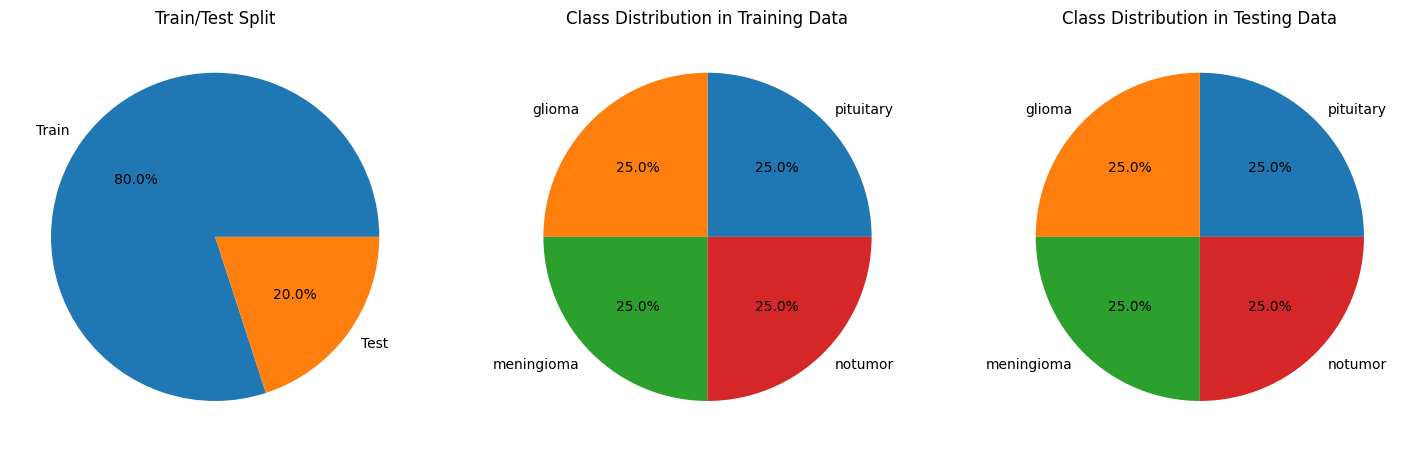

In [ ]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=32,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=32,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# Functions to train model

In [ ]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.regularizers import l2
from keras.applications import ResNet50
import matplotlib.pyplot as plt

# Define the model creation function
def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # High dropout for robustness
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model training function
def train_model(model, train_generator, test_generator, model_name):
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=100,
        callbacks=[checkpoint, early_stopping]
    )
    return model, history

# Create/Load model

In [ ]:
# Check if the model exists, else create and train it
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    model = create_model((224, 224, 3), len(classes))

# Plot the model architecture
plot_model(model, to_file='resnet50_model.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model, history = train_model(model, train_generator, test_generator, model_file)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 4.9399 - accuracy: 0.4583
Epoch 1: val_loss improved from inf to 4.96237, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 13s 636ms/step - loss: 4.9399 - accuracy: 0.4583 - val_loss: 4.9624 - val_accuracy: 0.2500
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 3.4040 - accuracy: 0.5599
Epoch 2: val_loss improved from 4.96237 to 3.88473, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 9s 766ms/step - loss: 3.4040 - accuracy: 0.5599 - val_loss: 3.8847 - val_accuracy: 0.2500
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 2.6039 - accuracy: 0.5990
Epoch 3: val_loss improved from 3.88473 to 3.40555, saving model to resnet50_brain_mri.keras
12/12 [==============================] - 6s 519ms/step - loss: 2.6039 - accuracy: 0.5990 - val_loss: 3.4056 - val_accuracy: 0.2500
Epoch 4/100
12/12 [===========================

# Testing the model

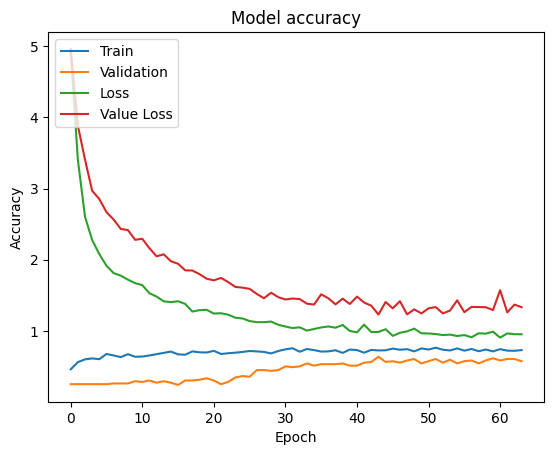

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

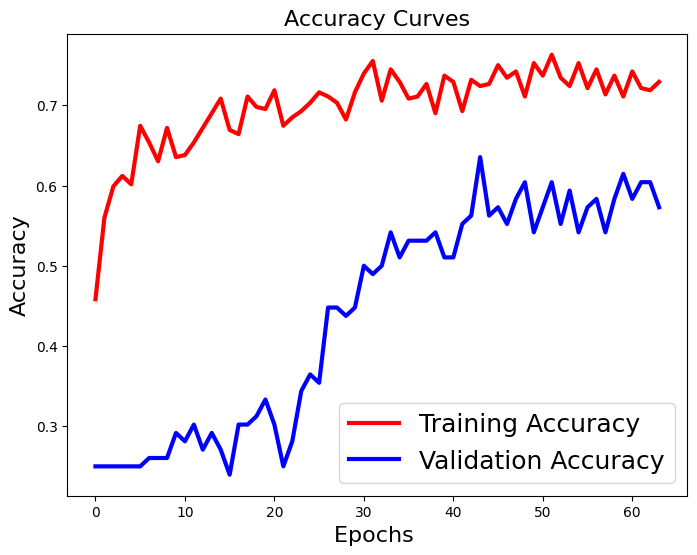

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

# Validate with external test data

3/3 [==============================] - 2s 123ms/step - loss: 1.2288 - accuracy: 0.6354


3/3 [==============================] - 2s 122ms/step


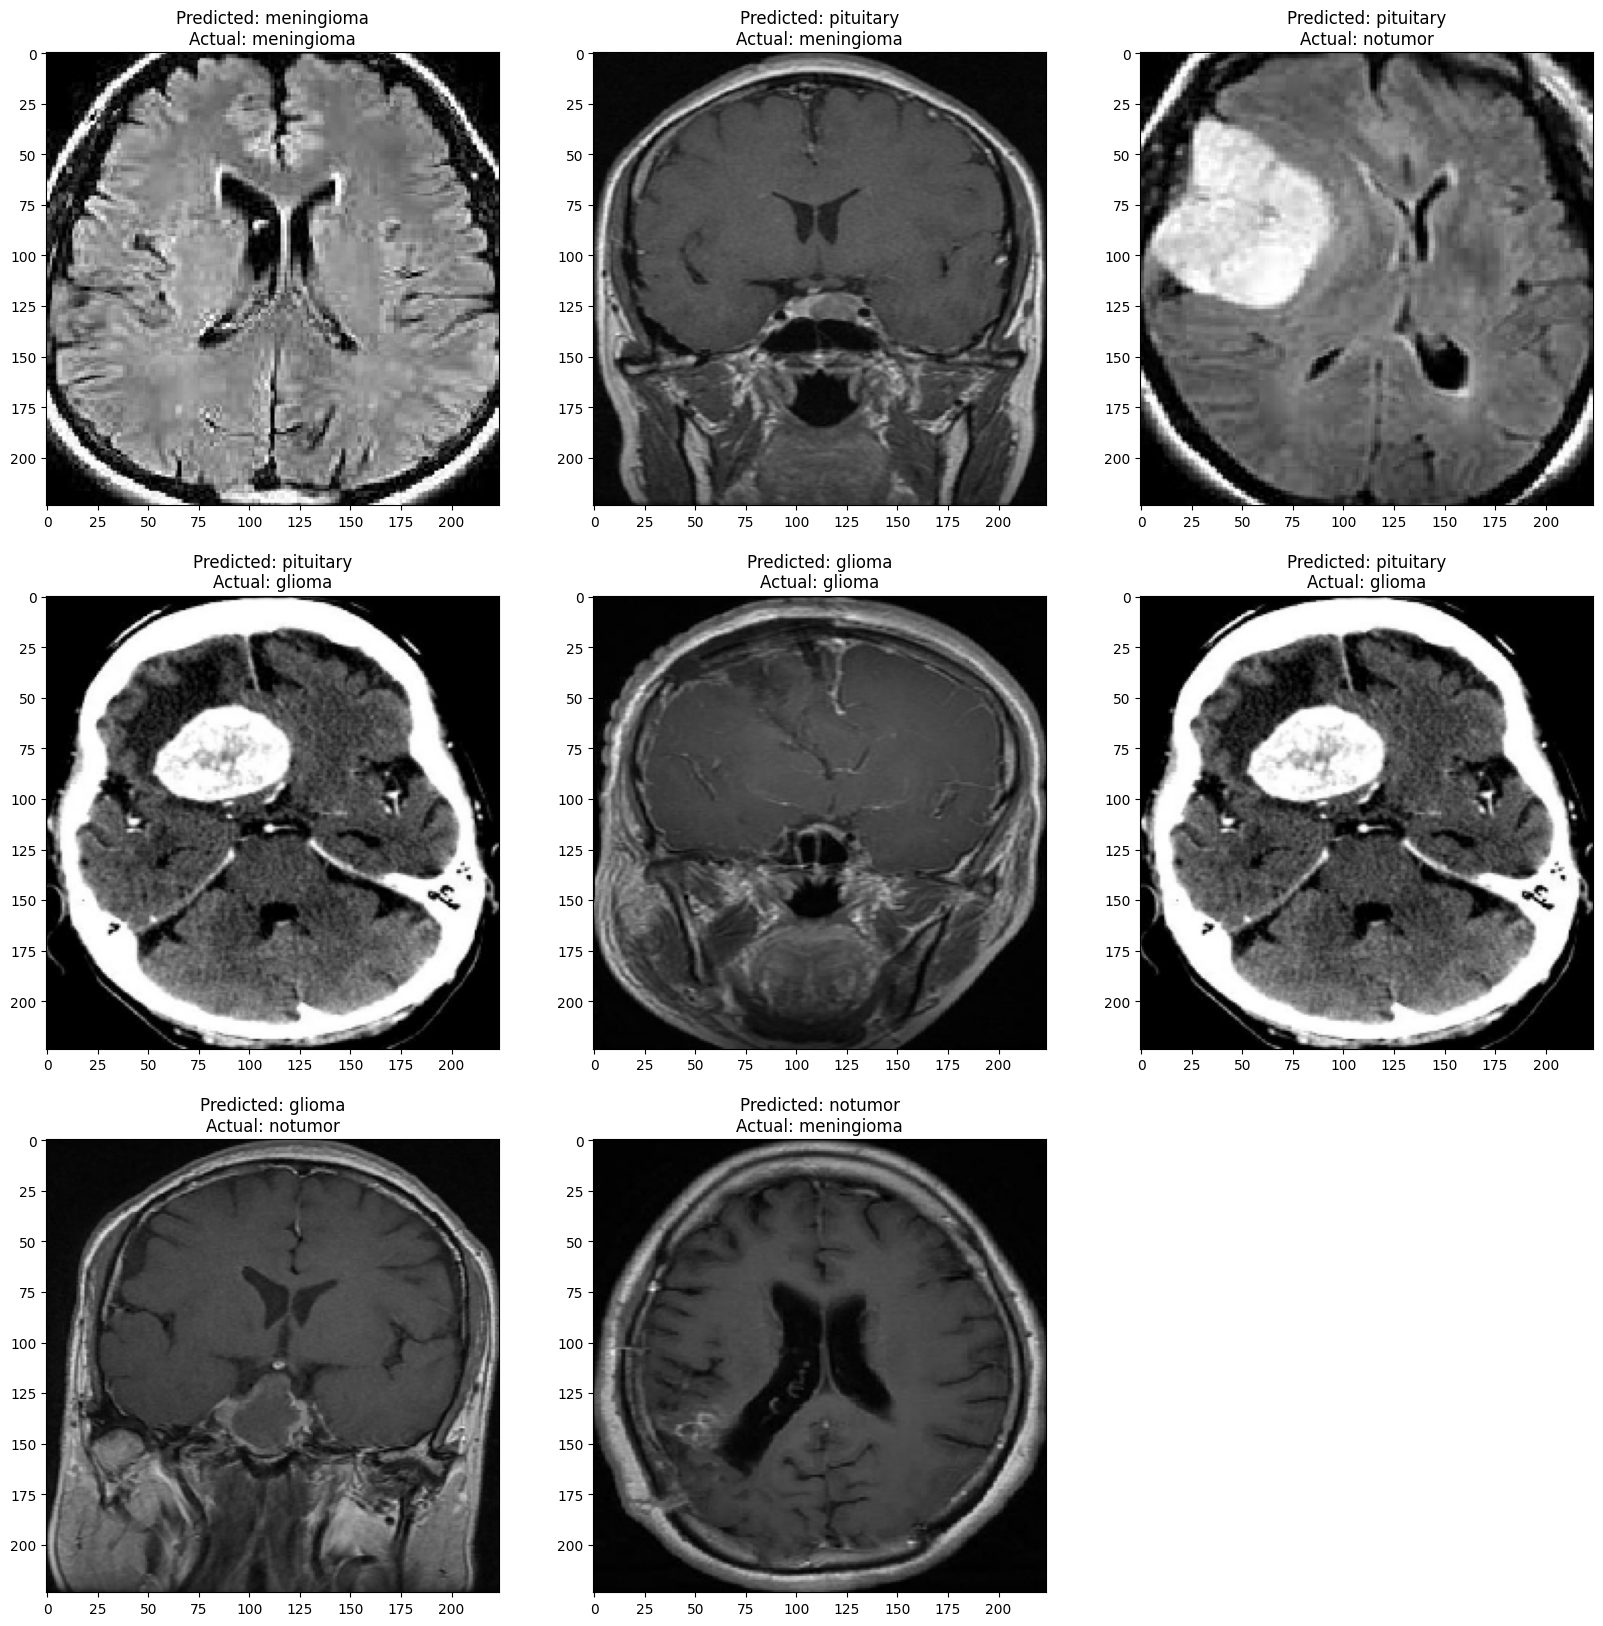

In [ ]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break

# Model visualization(Evaluation)

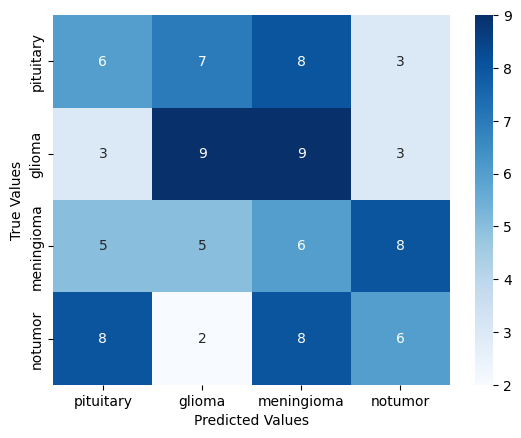

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.2836893448826844, Sensitivity: 0.28125, Specificity: 0.7604166666666667, Accuracy: 0.28125
